In [2]:
pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 69.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Matplotlib is building the font cache; this may take a moment.


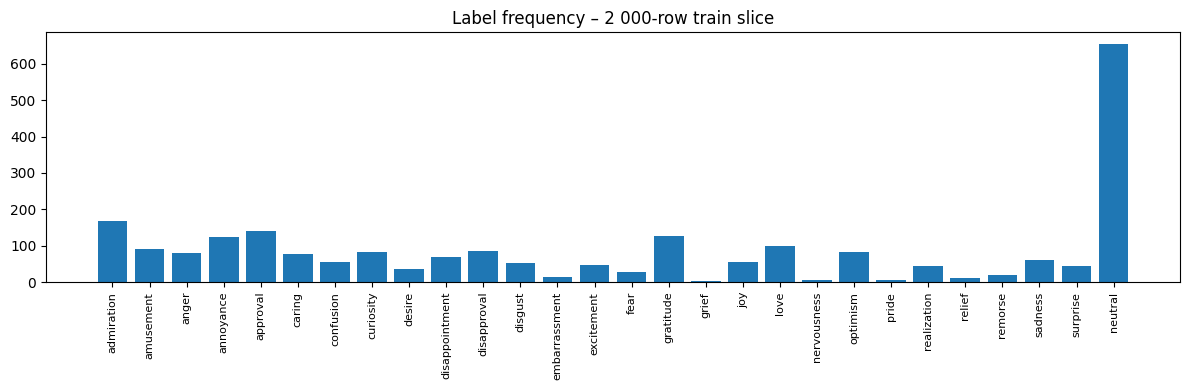

In [3]:
from datasets import load_from_disk
import matplotlib.pyplot as plt
import numpy as np

ds = load_from_disk("../data/goemo_small")["train"]

# count frequency of each of 28 labels
counts = np.zeros(28, dtype=int)
for lbls in ds["emotion"]:      # still original column in saved file
    for idx in lbls:
        counts[idx] += 1

label_names = [
    "admiration","amusement","anger","annoyance","approval","caring",
    "confusion","curiosity","desire","disappointment","disapproval",
    "disgust","embarrassment","excitement","fear","gratitude",
    "grief","joy","love","nervousness","optimism","pride",
    "realization","relief","remorse","sadness","surprise","neutral"
]

plt.figure(figsize=(12,4))
plt.bar(range(28), counts)
plt.xticks(range(28), label_names, rotation=90, fontsize=8)
plt.title("Label frequency – 2 000-row train slice")
plt.tight_layout()
plt.show()


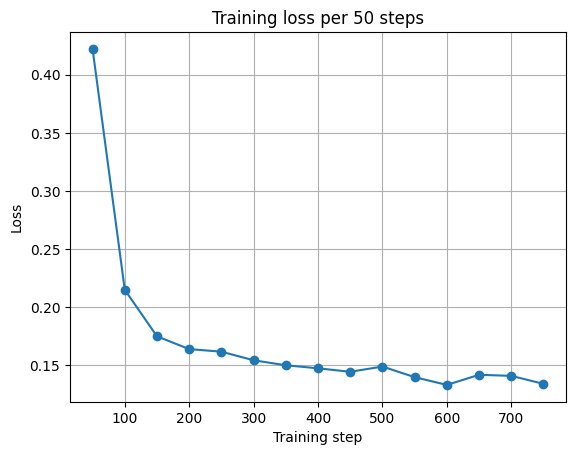

In [4]:
import json, pathlib, matplotlib.pyplot as plt

log_path = max(pathlib.Path("../").rglob("trainer_state.json"))  # latest run
state = json.load(open(log_path))

train_loss = state["log_history"]
steps, losses = zip(*[(l["step"], l["loss"])
                      for l in train_loss if "loss" in l])

plt.figure()
plt.plot(steps, losses, marker="o")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training loss per 50 steps")
plt.grid(True)
plt.show()



In [5]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# preds / labels from eval.py
preds = np.load("../notebooks/preds.npy")    # or rerun code to grab arrays
labels = np.load("../notebooks/labels.npy")

# choose one label e.g., 'anger' index-2
cm = multilabel_confusion_matrix(labels, preds)[2]   # TN, FP, FN, TP

plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.colorbar()
plt.xticks([0,1], ["negative","positive"])
plt.yticks([0,1], ["negative","positive"])
plt.title("Binary confusion matrix – anger")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../notebooks/preds.npy'

In [6]:
import torch, numpy as np
from datasets import load_from_disk
from transformers import AutoModelForSequenceClassification

# load tokenized test set and model
ds = load_from_disk("../data/goemo_small")["test"]
model = AutoModelForSequenceClassification.from_pretrained("../checkpoints/best")
model.eval()

# ensure labels are float32 multi-hot vectors
def to_multihot(example):
    vec = np.zeros(28, dtype=np.float32)
    for idx in example["emotion"]:   # raw column name is still 'emotion'
        vec[idx] = 1.0
    example["labels"] = vec
    return example

ds = ds.map(to_multihot, batched=False)
labels = np.stack(ds["labels"])

# generate predictions
preds = []
with torch.no_grad():
    for i in range(len(ds)):
        batch = {
            "input_ids":      torch.tensor(ds["input_ids"][i]).unsqueeze(0),
            "attention_mask": torch.tensor(ds["attention_mask"][i]).unsqueeze(0)
        }
        logits = model(**batch).logits
        pred = (logits.sigmoid() > 0.5).cpu().numpy()
        preds.append(pred)

preds = np.vstack(preds).astype(int)


Map: 100%|███████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 4518.50 examples/s]


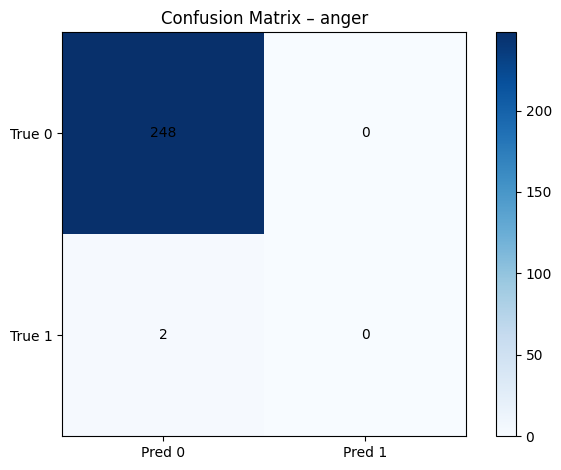

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# Pick a label, e.g., 2 = "anger"
label_names = [
    "admiration","amusement","anger","annoyance","approval","caring",
    "confusion","curiosity","desire","disappointment","disapproval",
    "disgust","embarrassment","excitement","fear","gratitude",
    "grief","joy","love","nervousness","optimism","pride",
    "realization","relief","remorse","sadness","surprise","neutral"
]

index = 2  # anger
cm = multilabel_confusion_matrix(labels, preds)[index]

plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks([0,1], ["Pred 0","Pred 1"])
plt.yticks([0,1], ["True 0","True 1"])
plt.title(f"Confusion Matrix – {label_names[index]}")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.tight_layout()
plt.show()
